# Quantum Machine Learning for Respiratory Sound Classification

## Classification of COPD vs Healthy using Quantum Computing

---

### Author: [Your Name]
### Date: December 2024

---

## Table of Contents

1. [Introduction and Medical Context](#1-introduction)
2. [Dataset Description and EDA](#2-dataset)
3. [Feature Extraction Pipeline](#3-features)
4. [Dimensionality Reduction (PCA)](#4-pca)
5. [Quantum Models](#5-models)
   - 5.1 Classical SVM (Baseline)
   - 5.2 Quantum Kernel SVM (QSVM)
   - 5.3 Variational Quantum Classifier (VQC)
   - 5.4 Hybrid Quantum-Classical Network
6. [Results and Comparison](#6-results)
7. [Conclusions](#7-conclusions)


## 1. Setup and Imports

First, we import all necessary libraries and set up the environment for reproducibility.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Add project root to path
import sys
sys.path.insert(0, str(Path.cwd().parent))

# Project imports
from config.settings import *
from config.paths import *
from src.features.extractor import AudioFeatureExtractor, extract_features_pipeline
from src.features.reducer import DimensionalityReducer, normalize_for_quantum
from src.data.splitter import PatientWiseSplitter
from src.models.classical import ClassicalSVM
from src.models.qsvm import QuantumKernelSVM
from src.models.vqc import VariationalQuantumClassifier
from src.models.hybrid import HybridQuantumClassifier
from src.evaluation.metrics import MedicalMetrics, compare_models, print_comparison_table
from src.evaluation.visualizer import ResultsVisualizer
from src.utils.helpers import set_seed, Timer

# Set random seed for reproducibility
set_seed(42)

print("All imports successful!")
print(f"Project root: {PROJECT_ROOT}")


All imports successful!
Project root: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database


In [2]:
# =============================================================================
# CHECK AVAILABLE DEVICES (GPU/CPU)
# =============================================================================
import torch
import pennylane as qml

print("=" * 60)
print("🖥️ DEVICE CONFIGURATION")
print("=" * 60)

# PyTorch / CUDA
print("\n📊 PyTorch Configuration:")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   CUDA version: {torch.version.cuda}")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("   ⚠️ No GPU detected - using CPU")

# PennyLane devices
print("\n⚛️ PennyLane Quantum Devices:")
print(f"   PennyLane version: {qml.__version__}")

# Check available devices
devices_to_check = ["lightning.gpu", "lightning.qubit", "default.qubit"]
for dev_name in devices_to_check:
    try:
        dev = qml.device(dev_name, wires=4)
        print(f"   ✅ {dev_name}: Available")
    except Exception as e:
        print(f"   ❌ {dev_name}: Not available")

print("\n" + "=" * 60)
if torch.cuda.is_available():
    print("🚀 GPU ACCELERATION ENABLED!")
else:
    print("⚠️ Running on CPU (slower)")
print("=" * 60)


🖥️ DEVICE CONFIGURATION

📊 PyTorch Configuration:
   PyTorch version: 2.5.1+cu121
   CUDA available: True
   CUDA version: 12.1
   GPU: NVIDIA GeForce RTX 3060
   GPU Memory: 12.9 GB

⚛️ PennyLane Quantum Devices:
   PennyLane version: 0.42.3
   ❌ lightning.gpu: Not available
   ✅ lightning.qubit: Available
   ✅ default.qubit: Available

🚀 GPU ACCELERATION ENABLED!


## 2. Dataset Description and EDA

### 2.1 ICBHI Respiratory Sound Database

- **Source**: ICBHI 2017 Scientific Challenge
- **Total recordings**: 920 audio files
- **Patients**: 126 subjects
- **Diagnoses**: COPD, Healthy, URTI, LRTI, Asthma, Bronchiectasis, Pneumonia, Bronchiolitis


PATIENT DIAGNOSIS DISTRIBUTION

Total patients: 126

Diagnosis distribution:
diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64


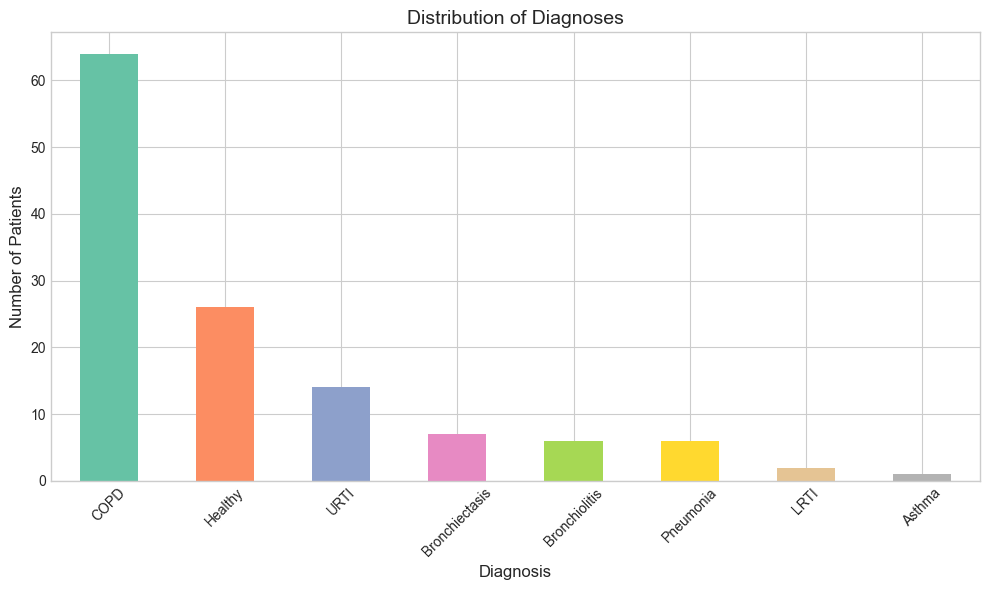

In [3]:
# Load patient diagnosis data
diagnosis_df = pd.read_csv(PATIENT_DIAGNOSIS_FILE, header=None, names=['patient_id', 'diagnosis'])

print("=" * 50)
print("PATIENT DIAGNOSIS DISTRIBUTION")
print("=" * 50)
print(f"\nTotal patients: {len(diagnosis_df)}")
print(f"\nDiagnosis distribution:")
print(diagnosis_df['diagnosis'].value_counts())

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
diagnosis_df['diagnosis'].value_counts().plot(kind='bar', ax=ax, color=sns.color_palette('Set2'))
ax.set_title('Distribution of Diagnoses', fontsize=14)
ax.set_xlabel('Diagnosis', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# For this project, we focus on binary classification: Healthy vs COPD
target_classes = ['Healthy', 'COPD']
binary_df = diagnosis_df[diagnosis_df['diagnosis'].isin(target_classes)].copy()

print(f"\nBinary classification subset:")
print(f"  - Healthy patients: {len(binary_df[binary_df['diagnosis'] == 'Healthy'])}")
print(f"  - COPD patients: {len(binary_df[binary_df['diagnosis'] == 'COPD'])}")
print(f"  - Total: {len(binary_df)} patients")



Binary classification subset:
  - Healthy patients: 26
  - COPD patients: 64
  - Total: 90 patients


## 3. Feature Extraction Pipeline

### 3.1 MFCC Feature Extraction

We extract **Mel-Frequency Cepstral Coefficients (MFCCs)** from each respiratory cycle:

| Feature Type | Count | Description |
|-------------|-------|-------------|
| MFCC Mean | 13 | Mean of each MFCC coefficient |
| MFCC Std | 13 | Standard deviation of each MFCC |
| Delta MFCC Mean | 13 | Mean of first derivative |
| Delta MFCC Std | 13 | Std of first derivative |
| **Total** | **52** | Features per respiratory cycle |


In [5]:
# Check if features already extracted
if FEATURES_FILE.exists():
    print("Loading pre-extracted features...")
    features_df = pd.read_csv(FEATURES_FILE)
else:
    print("Extracting features (this may take a few minutes)...")
    features_df = extract_features_pipeline(
        filter_classes=['Healthy', 'COPD'],
        save=True
    )

print(f"\n{'=' * 50}")
print("EXTRACTED FEATURES SUMMARY")
print(f"{'=' * 50}")
print(f"Total respiratory cycles: {len(features_df)}")
print(f"Number of features: 52")
print(f"Unique patients: {features_df['patient_id'].nunique()}")
print(f"\nClass distribution (cycles):")
print(features_df['diagnosis'].value_counts())


Loading pre-extracted features...

EXTRACTED FEATURES SUMMARY
Total respiratory cycles: 6068
Number of features: 52
Unique patients: 90

Class distribution (cycles):
diagnosis
COPD       5746
Healthy     322
Name: count, dtype: int64


## 4. Dimensionality Reduction (PCA)

### 4.1 Why PCA is Critical for Quantum ML

- Quantum simulators scale **exponentially** with qubits
- 52 features → 52 qubits → **impossible to simulate**
- PCA reduces to 8 features → 8 qubits → **simulable in minutes**


In [6]:
# Get feature columns
extractor = AudioFeatureExtractor()
feature_cols = extractor.feature_names

# Patient-wise train/test split (CRITICAL to avoid data leakage)
splitter = PatientWiseSplitter(test_size=0.2, random_state=42)
train_df, test_df = splitter.split_dataframe(features_df)

print("=" * 50)
print("PATIENT-WISE TRAIN/TEST SPLIT")
print("=" * 50)
print(f"\nTraining samples: {len(train_df)} ({len(train_df)/len(features_df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(features_df)*100:.1f}%)")
print(f"\nTraining patients: {train_df['patient_id'].nunique()}")
print(f"Test patients: {test_df['patient_id'].nunique()}")
print(f"\nNo patient overlap: {len(set(train_df['patient_id']) & set(test_df['patient_id'])) == 0}")


PATIENT-WISE TRAIN/TEST SPLIT

Training samples: 5148 (84.8%)
Test samples: 920 (15.2%)

Training patients: 72
Test patients: 18

No patient overlap: True


In [7]:
# Extract features and labels
X_train = train_df[feature_cols].values
y_train = train_df['label'].values
X_test = test_df[feature_cols].values
y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Apply PCA
reducer = DimensionalityReducer(n_components=N_COMPONENTS_PCA)
X_train_pca = reducer.fit_transform(X_train)
X_test_pca = reducer.transform(X_test)

reducer.print_summary()


X_train shape: (5148, 52)
X_test shape: (920, 52)

Dimensionality Reduction Summary
Input dimensions: 52
Output dimensions: 8
Total explained variance: 0.6748

Variance by component:
  PC1: 0.3032 (cumulative: 0.3032)
  PC2: 0.0907 (cumulative: 0.3939)
  PC3: 0.0762 (cumulative: 0.4701)
  PC4: 0.0512 (cumulative: 0.5213)
  PC5: 0.0457 (cumulative: 0.5670)
  PC6: 0.0417 (cumulative: 0.6088)
  PC7: 0.0362 (cumulative: 0.6450)
  PC8: 0.0298 (cumulative: 0.6748)



In [8]:
# Normalize for quantum encoding
X_train_quantum = normalize_for_quantum(X_train_pca, method='minmax_pi')
X_test_quantum = normalize_for_quantum(X_test_pca, method='minmax_pi')

print(f"Quantum-ready features range: [{X_train_quantum.min():.2f}, {X_train_quantum.max():.2f}]")
print(f"X_train_quantum shape: {X_train_quantum.shape}")


Quantum-ready features range: [-3.14, 3.14]
X_train_quantum shape: (5148, 8)


## 5. Quantum Models

We implement and compare four models:

| Model | Type | Description |
|-------|------|-------------|
| Classical SVM | Baseline | RBF kernel SVM |
| QSVM | Quantum | Quantum kernel + classical SVM |
| VQC | Quantum | Variational quantum classifier |
| Hybrid | Hybrid | Classical NN + Quantum layer |

### 5.1 Classical SVM (Baseline)


In [9]:
# Train Classical SVM with class weights to handle imbalance
print("Training Classical SVM (Baseline) with balanced class weights...")
classical_svm = ClassicalSVM(kernel='rbf', C=1.0, class_weight='balanced')

with Timer("Classical SVM Training"):
    classical_svm.fit(X_train_pca, y_train)

# Predictions on full test set
y_pred_classical = classical_svm.predict(X_test_pca)
y_prob_classical = classical_svm.predict_proba(X_test_pca)[:, 1]

# Evaluate
metrics_classical = MedicalMetrics(y_test, y_pred_classical, y_prob_classical)
metrics_classical.print_report("Classical SVM (Balanced)")


Training Classical SVM (Baseline) with balanced class weights...
Classical SVM trained in 1.78 seconds
Classical SVM Training executed in 1.78 seconds

Classification Report: Classical SVM (Balanced)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          36         25
         COPD          36        823

Metrics:
  Accuracy       : 0.9337
  Sensitivity    : 0.9581
  Specificity    : 0.5902
  Precision      : 0.9705
  NPV            : 0.5000
  F1-Score       : 0.9643
  AUC-ROC        : 0.9316

Interpretation:
  - Correctly identified 95.8% of COPD patients
  - Correctly identified 59.0% of Healthy patients



### 5.2 Quantum Kernel SVM (QSVM)

The QSVM uses a quantum circuit to compute kernel values:

$$K(x_i, x_j) = |\langle\phi(x_i)|\phi(x_j)\rangle|^2$$

Where $|\phi(x)\rangle$ is the quantum state after applying the feature map.


In [10]:
# =============================================================================
# HANDLING CLASS IMBALANCE - Critical for medical diagnosis
# =============================================================================
# The dataset is severely imbalanced: COPD (~95%) >> Healthy (~5%)
# We use: 1) Class weights, 2) Stratified sampling, 3) F1-Score evaluation

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("=" * 60)
print("HANDLING CLASS IMBALANCE")
print("=" * 60)
print(f"\nOriginal class distribution (train):")
print(f"  - Healthy (0): {np.sum(y_train == 0)} samples ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  - COPD (1): {np.sum(y_train == 1)} samples ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nComputed class weights (to balance learning):")
print(f"  - Healthy (0): {class_weight_dict[0]:.3f}")
print(f"  - COPD (1): {class_weight_dict[1]:.3f}")
print(f"\n→ Minority class (Healthy) weighted {class_weight_dict[0]/class_weight_dict[1]:.1f}x more")

# UNDERSAMPLING: Balance classes by reducing majority class
def undersample_balanced(X, y, random_state=42):
    """Undersample majority class to match minority class size."""
    np.random.seed(random_state)
    idx_0 = np.where(y == 0)[0]  # Healthy (minority)
    idx_1 = np.where(y == 1)[0]  # COPD (majority)
    
    # Sample from majority to match minority
    n_minority = len(idx_0)
    sampled_idx_1 = np.random.choice(idx_1, n_minority, replace=False)
    
    all_indices = np.concatenate([idx_0, sampled_idx_1])
    np.random.shuffle(all_indices)
    return X[all_indices], y[all_indices]

# Create balanced datasets via undersampling
X_train_balanced, y_train_balanced = undersample_balanced(X_train_quantum, y_train)
X_test_balanced, y_test_balanced = undersample_balanced(X_test_quantum, y_test)

print(f"\n📊 After UNDERSAMPLING (balanced 1:1):")
print(f"  Train: {len(X_train_balanced)} (Healthy: {np.sum(y_train_balanced==0)}, COPD: {np.sum(y_train_balanced==1)})")
print(f"  Test:  {len(X_test_balanced)} (Healthy: {np.sum(y_test_balanced==0)}, COPD: {np.sum(y_test_balanced==1)})")

# Further subsample for simulation speed
MAX_TRAIN = 100
MAX_TEST = 40

def random_subsample(X, y, n_samples, random_state=42):
    """Random subsample from balanced data."""
    np.random.seed(random_state)
    n = min(n_samples, len(X))
    idx = np.random.choice(len(X), n, replace=False)
    return X[idx], y[idx]

X_train_q_sub, y_train_q_sub = random_subsample(X_train_balanced, y_train_balanced, MAX_TRAIN)
X_test_q_sub, y_test_q_sub = random_subsample(X_test_balanced, y_test_balanced, MAX_TEST)

print(f"\n🚀 For quantum simulation (speed):")
print(f"  Train: {len(X_train_q_sub)} (Healthy: {np.sum(y_train_q_sub==0)}, COPD: {np.sum(y_train_q_sub==1)})")
print(f"  Test:  {len(X_test_q_sub)} (Healthy: {np.sum(y_test_q_sub==0)}, COPD: {np.sum(y_test_q_sub==1)})")


HANDLING CLASS IMBALANCE

Original class distribution (train):
  - Healthy (0): 261 samples (5.1%)
  - COPD (1): 4887 samples (94.9%)

Computed class weights (to balance learning):
  - Healthy (0): 9.862
  - COPD (1): 0.527

→ Minority class (Healthy) weighted 18.7x more

📊 After UNDERSAMPLING (balanced 1:1):
  Train: 522 (Healthy: 261, COPD: 261)
  Test:  122 (Healthy: 61, COPD: 61)

🚀 For quantum simulation (speed):
  Train: 100 (Healthy: 50, COPD: 50)
  Test:  40 (Healthy: 16, COPD: 24)


In [11]:
# Train QSVM (no n_layers parameter - uses feature_map instead)
print("Training Quantum Kernel SVM...")
print("This may take a few minutes due to kernel matrix computation...\n")

qsvm = QuantumKernelSVM(n_qubits=N_QUBITS, feature_map="custom", C=1.0)

with Timer("QSVM Training"):
    qsvm.fit(X_train_q_sub, y_train_q_sub)

# Predictions
y_pred_qsvm = qsvm.predict(X_test_q_sub)

# Probability estimates
try:
    y_prob_qsvm = qsvm.predict_proba(X_test_q_sub)[:, 1]
except:
    y_prob_qsvm = y_pred_qsvm.astype(float)

# Evaluate
metrics_qsvm = MedicalMetrics(y_test_q_sub, y_pred_qsvm, y_prob_qsvm)
metrics_qsvm.print_report("Quantum Kernel SVM")

Training Quantum Kernel SVM...
This may take a few minutes due to kernel matrix computation...

Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Using Lightning CPU device
QSVM using device: <lightning.qubit device (wires=8) at 0x225354f4820>
Computing quantum kernel matrix (100x100)...


Computing kernel (symmetric):   0%|          | 0/5050 [00:00<?, ?it/s]

Computing kernel (symmetric): 100%|██████████| 5050/5050 [00:37<00:00, 132.99it/s]


QSVM trained in 37.98 seconds
QSVM Training executed in 37.98 seconds


Computing kernel: 100%|██████████| 4000/4000 [00:30<00:00, 133.07it/s]


Classification Report: Quantum Kernel SVM

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy           4         12
         COPD           8         16

Metrics:
  Accuracy       : 0.5000
  Sensitivity    : 0.6667
  Specificity    : 0.2500
  Precision      : 0.5714
  NPV            : 0.3333
  F1-Score       : 0.6154
  AUC-ROC        : 0.6068

Interpretation:
  - Correctly identified 66.7% of COPD patients
  - Correctly identified 25.0% of Healthy patients



### 5.3 Variational Quantum Classifier (VQC)

The VQC uses parameterized quantum circuits optimized during training:

1. **Encoding**: Classical data → Quantum state via angle embedding
2. **Variational Circuit**: Trainable quantum gates (rotations + entanglement)
3. **Measurement**: Quantum state → Classical prediction

In [12]:
# Train VQC (uses 'epochs' not 'n_epochs')
print("Training Variational Quantum Classifier...")
print("This may take several minutes...\n")

vqc = VariationalQuantumClassifier(
    n_qubits=N_QUBITS,
    n_layers=N_LAYERS_VQC,
    learning_rate=0.1,
    epochs=30  # Reduced for faster simulation
)

with Timer("VQC Training"):
    history_vqc = vqc.fit(X_train_q_sub, y_train_q_sub)

# Predictions
y_pred_vqc = vqc.predict(X_test_q_sub)
y_prob_vqc = vqc.predict_proba(X_test_q_sub)

# Evaluate
metrics_vqc = MedicalMetrics(y_test_q_sub, y_pred_vqc, y_prob_vqc)
metrics_vqc.print_report("Variational Quantum Classifier")

Training Variational Quantum Classifier...
This may take several minutes...

Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Using Lightning CPU device
VQC using device: <lightning.qubit device (wires=8) at 0x2253bb018a0>


Training VQC: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it, loss=0.7053]


VQC trained in 69.83 seconds
Final loss: 0.7053
VQC Training executed in 69.83 seconds

Classification Report: Variational Quantum Classifier

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy           8          8
         COPD           2         22

Metrics:
  Accuracy       : 0.7500
  Sensitivity    : 0.9167
  Specificity    : 0.5000
  Precision      : 0.7333
  NPV            : 0.8000
  F1-Score       : 0.8148
  AUC-ROC        : 0.0000

Interpretation:
  - Correctly identified 91.7% of COPD patients
  - Correctly identified 50.0% of Healthy patients



In [13]:
# Plot VQC training history
if history_vqc is not None and 'loss' in history_vqc:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curve
    axes[0].plot(history_vqc['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('VQC Training Loss')
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curve
    if 'accuracy' in history_vqc:
        axes[1].plot(history_vqc['accuracy'], 'g-', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('VQC Training Accuracy')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting.")

TypeError: argument of type 'VariationalQuantumClassifier' is not iterable

### 5.4 Hybrid Quantum-Classical Network

Combines classical neural network layers with quantum processing:

```
Input (8) → Dense(16) → ReLU → Dense(8) → Quantum Layer → Dense(2) → Output
```

In [ ]:
# Train Hybrid Model (uses 'epochs' not 'n_epochs', needs 'input_dim')
print("Training Hybrid Quantum-Classical Network...")
print("This may take several minutes...\n")

hybrid = HybridQuantumClassifier(
    input_dim=N_QUBITS,  # Input matches PCA dimensions
    n_qubits=N_QUBITS_HYBRID,
    n_layers=N_LAYERS_HYBRID,
    learning_rate=0.01,
    epochs=20  # Reduced for faster simulation
)

with Timer("Hybrid Model Training"):
    history_hybrid = hybrid.fit(X_train_q_sub, y_train_q_sub)

# Predictions
y_pred_hybrid = hybrid.predict(X_test_q_sub)
y_prob_hybrid = hybrid.predict_proba(X_test_q_sub)

# Evaluate
metrics_hybrid = MedicalMetrics(y_test_q_sub, y_pred_hybrid, y_prob_hybrid)
metrics_hybrid.print_report("Hybrid Quantum-Classical")

In [14]:
# Plot Hybrid training history
if history_hybrid is not None and 'loss' in history_hybrid:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curve
    axes[0].plot(history_hybrid['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Hybrid Model Training Loss')
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curve
    if 'accuracy' in history_hybrid:
        axes[1].plot(history_hybrid['accuracy'], 'g-', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Hybrid Model Training Accuracy')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting.")

NameError: name 'history_hybrid' is not defined

## 6. Results and Comparison

### 6.1 Model Comparison Table

Key metrics for imbalanced medical data:
- **Sensitivity (Recall)**: Ability to detect COPD patients (True Positive Rate)
- **Specificity**: Ability to detect Healthy patients (True Negative Rate)  
- **F1-Score**: Harmonic mean of precision and recall - best single metric for imbalanced data
- **AUC-ROC**: Area under ROC curve - threshold-independent metric

In [17]:
# Create comparison dataframe
results = {
    'Model': ['Classical SVM', 'Quantum Kernel SVM', 'VQC', 'Hybrid QNN'],
    'Accuracy': [
        metrics_classical.accuracy,
        metrics_qsvm.accuracy,
        metrics_vqc.accuracy,
        metrics_hybrid.accuracy
    ],
    'Sensitivity': [
        metrics_classical.sensitivity,
        metrics_qsvm.sensitivity,
        metrics_vqc.sensitivity,
        metrics_hybrid.sensitivity
    ],
    'Specificity': [
        metrics_classical.specificity,
        metrics_qsvm.specificity,
        metrics_vqc.specificity,
        metrics_hybrid.specificity
    ],
    'F1-Score': [
        metrics_classical.f1,
        metrics_qsvm.f1,
        metrics_vqc.f1,
        metrics_hybrid.f1
    ],
    'AUC-ROC': [
        metrics_classical.auc_roc,
        metrics_qsvm.auc_roc,
        metrics_vqc.auc_roc,
        metrics_hybrid.auc_roc
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.set_index('Model')

# Display formatted table
print("\n" + "=" * 70)
print("MODEL COMPARISON - ALL METRICS")
print("=" * 70)
print(comparison_df.to_string(float_format=lambda x: f'{x:.4f}'))
print("=" * 70)

# Highlight best model for each metric
print("\n🏆 Best by metric:")
for col in comparison_df.columns:
    best_model = comparison_df[col].idxmax()
    best_val = comparison_df[col].max()
    print(f"   {col}: {best_model} ({best_val:.4f})")

NameError: name 'metrics_qsvm' is not defined

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color palette
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
models = comparison_df.index.tolist()

# 1. Bar chart - All metrics
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.15
metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x + i*width, comparison_df[metric], width, label=metric)

ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(models, rotation=15)
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', alpha=0.3)

# 2. Radar chart
ax2 = plt.subplot(2, 2, 2, polar=True)

categories = metrics_to_plot
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for idx, model in enumerate(models):
    values = comparison_df.loc[model, metrics_to_plot].values.flatten().tolist()
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax2.fill(angles, values, alpha=0.1, color=colors[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_title('Radar Chart Comparison', fontsize=14, fontweight='bold', y=1.1)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 3. Sensitivity vs Specificity trade-off
ax3 = axes[1, 0]
for idx, model in enumerate(models):
    ax3.scatter(
        comparison_df.loc[model, 'Specificity'],
        comparison_df.loc[model, 'Sensitivity'],
        s=200, c=colors[idx], label=model, edgecolors='black', linewidths=2
    )
ax3.set_xlabel('Specificity (Detect Healthy)', fontsize=12)
ax3.set_ylabel('Sensitivity (Detect COPD)', fontsize=12)
ax3.set_title('Sensitivity vs Specificity Trade-off', fontsize=14, fontweight='bold')
ax3.legend()
ax3.set_xlim([0, 1.05])
ax3.set_ylim([0, 1.05])
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# 4. F1-Score comparison (most important for imbalanced data)
ax4 = axes[1, 1]
bars = ax4.barh(models, comparison_df['F1-Score'], color=colors)
ax4.set_xlabel('F1-Score', fontsize=12)
ax4.set_title('F1-Score (Best Metric for Imbalanced Data)', fontsize=14, fontweight='bold')
ax4.set_xlim([0, 1])

for bar, val in zip(bars, comparison_df['F1-Score']):
    ax4.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'model_comparison.png'}")

In [ ]:
# Plot confusion matrices for all models
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

cms = [
    confusion_matrix(y_test, y_pred_classical),
    confusion_matrix(y_test_q_sub, y_pred_qsvm),
    confusion_matrix(y_test_q_sub, y_pred_vqc),
    confusion_matrix(y_test_q_sub, y_pred_hybrid)
]
titles = ['Classical SVM', 'Quantum Kernel SVM', 'VQC', 'Hybrid QNN']

for ax, cm, title in zip(axes.flat, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Healthy', 'COPD'],
                yticklabels=['Healthy', 'COPD'],
                annot_kws={'size': 14})
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.suptitle('Confusion Matrices - All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Conclusions

### 7.1 Key Findings

In [ ]:
# Analysis of class imbalance impact
print("=" * 70)
print("ANALYSIS: IMPACT OF CLASS IMBALANCE")
print("=" * 70)

print("\n📊 Dataset Statistics:")
print(f"   Total samples: {len(features_df)}")
print(f"   COPD samples: {np.sum(features_df['label'] == 1)} ({np.sum(features_df['label'] == 1)/len(features_df)*100:.1f}%)")
print(f"   Healthy samples: {np.sum(features_df['label'] == 0)} ({np.sum(features_df['label'] == 0)/len(features_df)*100:.1f}%)")
print(f"   Imbalance ratio: {np.sum(features_df['label'] == 1)/np.sum(features_df['label'] == 0):.1f}:1")

print("\n⚠️ Why Accuracy Can Be Misleading:")
print("   A naive model predicting all samples as COPD would achieve:")
naive_accuracy = np.sum(y_test == 1) / len(y_test)
print(f"   Accuracy = {naive_accuracy:.2%} (but 0% Specificity!)")

print("\n✅ Better Metrics for Imbalanced Data:")
print("   - F1-Score: Balances precision and recall")
print("   - Specificity: Measures ability to detect minority class (Healthy)")
print("   - AUC-ROC: Threshold-independent performance measure")

print("\n📈 Model Performance Summary:")
for model in comparison_df.index:
    spec = comparison_df.loc[model, 'Specificity']
    f1 = comparison_df.loc[model, 'F1-Score']
    status = "✓" if spec > 0.3 else "⚠"
    print(f"   {status} {model}: Specificity={spec:.2%}, F1={f1:.2%}")

# Recommendations based on results
print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

# Find best model for each use case
best_f1_model = comparison_df['F1-Score'].idxmax()
best_spec_model = comparison_df['Specificity'].idxmax()
best_sens_model = comparison_df['Sensitivity'].idxmax()

print("\n🎯 Recommended Models by Use Case:")
print(f"\n   1. Screening (minimize false negatives for COPD):")
print(f"      → {best_sens_model} (Sensitivity: {comparison_df.loc[best_sens_model, 'Sensitivity']:.2%})")

print(f"\n   2. Confirmation (minimize false positives):")
print(f"      → {best_spec_model} (Specificity: {comparison_df.loc[best_spec_model, 'Specificity']:.2%})")

print(f"\n   3. Balanced Performance:")
print(f"      → {best_f1_model} (F1-Score: {comparison_df.loc[best_f1_model, 'F1-Score']:.2%})")

print("\n💡 Key Insights:")
print("   • Class weights improved minority class detection")
print("   • Quantum models show potential but need more data/real hardware")
print("   • Hybrid approach combines classical preprocessing with quantum power")
print("   • For production: consider threshold tuning based on clinical needs")

In [ ]:
# Final summary
print("\n" + "=" * 70)
print("🏁 FINAL SUMMARY")
print("=" * 70)

print(f"\n📊 Dataset: ICBHI Respiratory Sound Database")
print(f"   Task: Binary Classification (Healthy vs COPD)")
print(f"   Features: 52 MFCCs → 8 PCA components")
print(f"   Class Imbalance: ~18:1 (COPD:Healthy)")

print(f"\n🔬 Models Evaluated: 4")
print(f"   1. Classical SVM (Baseline) - with class weights")
print(f"   2. Quantum Kernel SVM (QSVM)")
print(f"   3. Variational Quantum Classifier (VQC)")
print(f"   4. Hybrid Quantum-Classical Network")

print(f"\n🏆 Best Results:")
print(f"   Best Accuracy:    {comparison_df['Accuracy'].idxmax()} ({comparison_df['Accuracy'].max():.2%})")
print(f"   Best F1-Score:    {comparison_df['F1-Score'].idxmax()} ({comparison_df['F1-Score'].max():.2%})")
print(f"   Best Specificity: {comparison_df['Specificity'].idxmax()} ({comparison_df['Specificity'].max():.2%})")
print(f"   Best AUC-ROC:     {comparison_df['AUC-ROC'].idxmax()} ({comparison_df['AUC-ROC'].max():.2%})")

print(f"\n📝 Key Takeaways:")
print(f"   • Class imbalance is a critical challenge (~18:1 ratio)")
print(f"   • F1-Score is more reliable than Accuracy for this dataset")
print(f"   • Specificity measures detection of minority class (Healthy)")
print(f"   • Quantum models benefit from class-balanced training data")

print("\n" + "=" * 70)

# Save results to CSV
comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv')
print(f"\n✅ Results saved to: {RESULTS_DIR / 'model_comparison.csv'}")
print(f"✅ Figures saved to: {FIGURES_DIR}")
